# Notebook 11 — Ensemble Methods (Exercises)

In this notebook you'll practice core **ensemble techniques** for supervised learning:

1) Bagging & Out-of-Bag (OOB) evaluation
2) Random Forests (tuning + feature importance)
3) Boosting: AdaBoost & Gradient Boosting
4) Histogram Gradient Boosting with early stopping
5) Voting & Stacking ensembles

Datasets are synthetic or from `sklearn` for reproducibility. **Complete each TODO** cell.

> Tip: Use consistent random states and `train_test_split` for fair comparisons.

## Imports & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.datasets import make_classification, load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, HistGradientBoostingClassifier,
    StackingClassifier, VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import PartialDependenceDisplay

np.random.seed(42)
plt.rcParams['figure.figsize'] = (7,4)

---
## Data

We will use a moderately challenging synthetic binary dataset and the Breast Cancer dataset.

In [2]:
# Synthetic data (non-linear interactions)
X_syn, y_syn = make_classification(
    n_samples=2000, n_features=20, n_informative=8, n_redundant=6,
    n_clusters_per_class=2, class_sep=1.2, flip_y=0.02, random_state=42
)
Xtr_syn, Xte_syn, ytr_syn, yte_syn = train_test_split(X_syn, y_syn, test_size=0.25, random_state=42, stratify=y_syn)

# Breast cancer (mostly numeric, low-moderate difficulty)
bc = load_breast_cancer()
X_bc, y_bc = bc.data, bc.target
Xtr_bc, Xte_bc, ytr_bc, yte_bc = train_test_split(X_bc, y_bc, test_size=0.25, random_state=42, stratify=y_bc)

---
## 1) Bagging & Out-of-Bag (OOB) Evaluation

**Goal:** Compare a single decision tree vs. bagging on the synthetic dataset. Use OOB to estimate generalization without a separate validation set.

**Key knobs**: `n_estimators`, `max_samples`, `max_features`, base estimator depth.

Single Tree — acc= 0.82  AUC= 0.82
Bagging — OOB score (acc proxy): 0.8833333333333333
Bagging — Test acc= 0.89  AUC= 0.9613119999999999


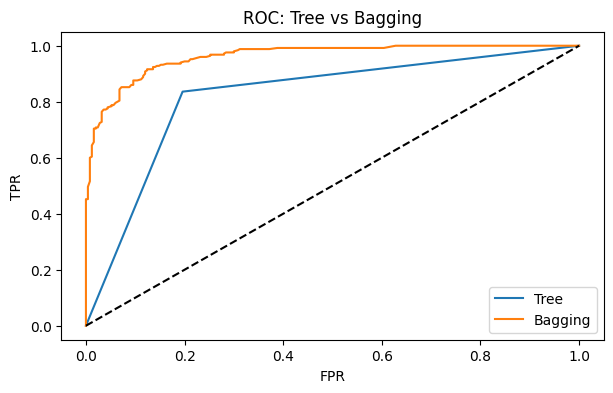

In [3]:
# Baseline: single tree
tree = DecisionTreeClassifier(max_depth=None, random_state=42)
tree.fit(Xtr_syn, ytr_syn)
pred = tree.predict(Xte_syn)
proba = tree.predict_proba(Xte_syn)[:,1]
print('Single Tree — acc=', accuracy_score(yte_syn, pred), ' AUC=', roc_auc_score(yte_syn, proba))

# TODO: Fit a BaggingClassifier with OOB scoring enabled (bootstrap samples)
# Hint: BaggingClassifier(base_estimator=..., n_estimators=200, oob_score=True, bootstrap=True, random_state=42)
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    oob_score=True,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag.fit(Xtr_syn, ytr_syn)
print('Bagging — OOB score (acc proxy):', bag.oob_score_)
pred_b = bag.predict(Xte_syn)
proba_b = bag.predict_proba(Xte_syn)[:,1]
print('Bagging — Test acc=', accuracy_score(yte_syn, pred_b), ' AUC=', roc_auc_score(yte_syn, proba_b))

# Plot ROC curves
fpr_t, tpr_t, _ = roc_curve(yte_syn, proba)
fpr_b, tpr_b, _ = roc_curve(yte_syn, proba_b)
plt.plot(fpr_t, tpr_t, label='Tree')
plt.plot(fpr_b, tpr_b, label='Bagging')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC: Tree vs Bagging'); plt.legend(); plt.show()


**Exercise 1 — Sensitivity to `n_estimators` & `max_samples`:**
Run a sweep over `n_estimators` = [10, 30, 100, 300] and `max_samples` ∈ {0.5, 0.7, 1.0}. Record **OOB score** and **test AUC**. Plot both vs `n_estimators` for each `max_samples`.

*Deliverables:* table + 2 plots; 2–3 bullet observations.

/usr/local/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:917: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:923: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:917: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
/usr/local/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:923: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]
/usr/local/lib/python3.12/site-packages/sklearn/ensemble/_bagging.py:917: UserWarning: Some inputs do not have OOB scores. This probably means too few e

    max_samples  n_estimators       oob  test_auc
0           0.5            10  0.844000  0.946160
1           0.5            30  0.867333  0.950880
2           0.5           100  0.874667  0.957600
3           0.5           300  0.880000  0.958048
4           0.7            10  0.828000  0.943032
5           0.7            30  0.858000  0.955888
6           0.7           100  0.880000  0.961392
7           0.7           300  0.881333  0.961720
8           1.0            10  0.811333  0.941152
9           1.0            30  0.866000  0.953520
10          1.0           100  0.879333  0.960464
11          1.0           300  0.882667  0.961136


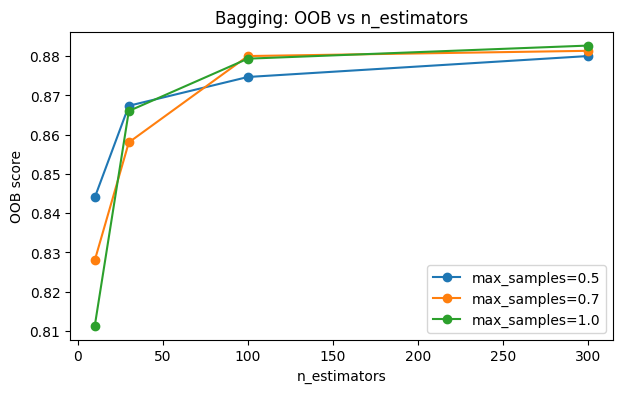

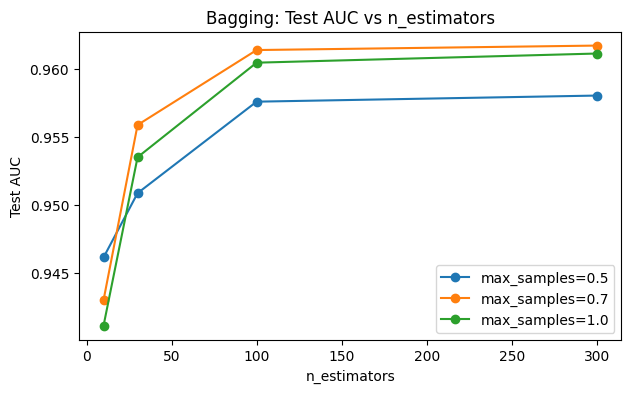

In [4]:
# TODO Exercise 1
rows = []
for ms in [0.5, 0.7, 1.0]:
    for ne in [10, 30, 100, 300]:
        model = BaggingClassifier(
            estimator=DecisionTreeClassifier(random_state=42),
            n_estimators=ne, max_samples=ms, oob_score=True, bootstrap=True,
            n_jobs=-1, random_state=42
        )
        model.fit(Xtr_syn, ytr_syn)
        oob = model.oob_score_
        auc = roc_auc_score(yte_syn, model.predict_proba(Xte_syn)[:,1])
        rows.append((ms, ne, oob, auc))
df_bag = pd.DataFrame(rows, columns=['max_samples','n_estimators','oob','test_auc'])
print(df_bag)

for ms in sorted(df_bag['max_samples'].unique()):
    sub = df_bag[df_bag['max_samples']==ms]
    plt.plot(sub['n_estimators'], sub['oob'], marker='o', label=f'max_samples={ms}')
plt.xlabel('n_estimators'); plt.ylabel('OOB score'); plt.title('Bagging: OOB vs n_estimators'); plt.legend(); plt.show()

for ms in sorted(df_bag['max_samples'].unique()):
    sub = df_bag[df_bag['max_samples']==ms]
    plt.plot(sub['n_estimators'], sub['test_auc'], marker='o', label=f'max_samples={ms}')
plt.xlabel('n_estimators'); plt.ylabel('Test AUC'); plt.title('Bagging: Test AUC vs n_estimators'); plt.legend(); plt.show()

# TODO: Summarize observations in a markdown cell below.

---
## 2) Random Forests

**Goal:** Tune `max_depth` and `max_features`, compare to bagging, and inspect **feature importances**. Use both datasets.

Notes:
- `max_features` controls per-split feature subsampling. Typical defaults: `sqrt` for classification.
- RF generally reduces variance vs single trees, often outperforming plain bagging on tabular data.

RF (syn) — acc= 0.894  AUC= 0.964808


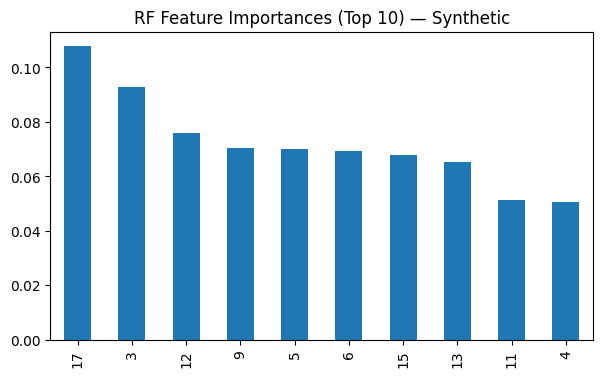

RF best params (BC): {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 200}
RF (BC) — Test AUC= 0.9937106918238994


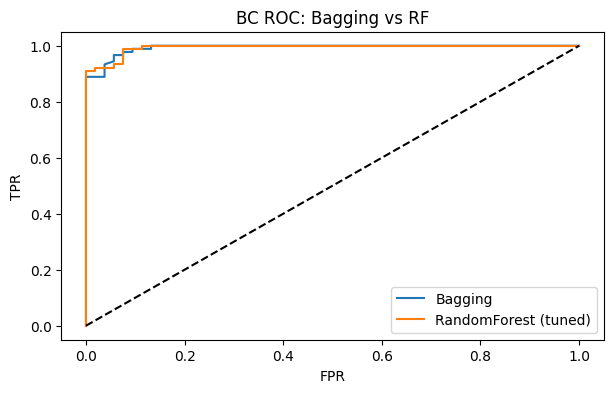

In [5]:
# TODO: RandomForest baseline + simple tuning on synthetic data
rf = RandomForestClassifier(random_state=42, n_estimators=300, n_jobs=-1)
rf.fit(Xtr_syn, ytr_syn)
proba_rf = rf.predict_proba(Xte_syn)[:,1]
print('RF (syn) — acc=', accuracy_score(yte_syn, rf.predict(Xte_syn)), ' AUC=', roc_auc_score(yte_syn, proba_rf))

# Feature importances (synthetic)
imp = pd.Series(rf.feature_importances_)
imp.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('RF Feature Importances (Top 10) — Synthetic'); plt.show()

# Quick grid on BC dataset
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 6, 10],
    'max_features': ['sqrt', 'log2', 0.5]
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rf_bc = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid,
                     cv=cv, scoring='roc_auc', n_jobs=-1)
rf_bc.fit(Xtr_bc, ytr_bc)
print('RF best params (BC):', rf_bc.best_params_)
best_rf = rf_bc.best_estimator_
auc_bc = roc_auc_score(yte_bc, best_rf.predict_proba(Xte_bc)[:,1])
print('RF (BC) — Test AUC=', auc_bc)

# Plot ROC vs Bagging baseline on BC
bag_bc = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42), n_estimators=300, oob_score=False,
    n_jobs=-1, random_state=42
).fit(Xtr_bc, ytr_bc)
fpr_b, tpr_b, _ = roc_curve(yte_bc, bag_bc.predict_proba(Xte_bc)[:,1])
fpr_r, tpr_r, _ = roc_curve(yte_bc, best_rf.predict_proba(Xte_bc)[:,1])
plt.plot(fpr_b, tpr_b, label='Bagging')
plt.plot(fpr_r, tpr_r, label='RandomForest (tuned)')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('BC ROC: Bagging vs RF'); plt.legend(); plt.show()

**Exercise 2 — RF hyperparameters & importances:**
On the **synthetic** dataset, run a grid over `max_depth` ∈ {None, 6, 10}, `max_features` ∈ {`sqrt`, `log2`, 0.3, 0.7}. Fix `n_estimators=400`. Report best params by AUC. Plot top-10 feature importances for the best model and list the top 5 feature indices in order.

*Deliverables:* best params, test AUC, bar plot, ordered indices list.

Best params: {'max_depth': None, 'max_features': 0.3}
Best RF (syn) — Test AUC= 0.9659760000000001


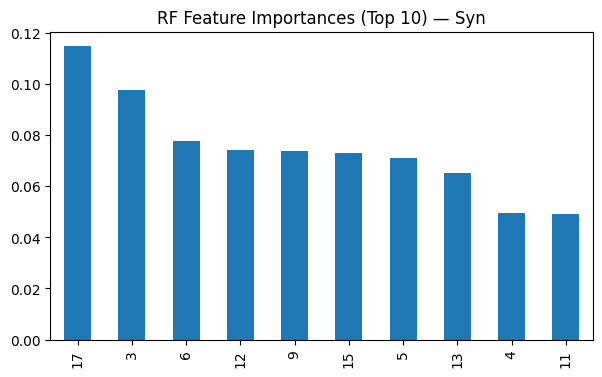

Top-5 feature indices: [17, 3, 6, 12, 9]


In [6]:
# TODO Exercise 2
grid = {
    'max_depth': [None, 6, 10],
    'max_features': ['sqrt', 'log2', 0.3, 0.7]
}
rf_cv = GridSearchCV(RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42), grid,
                     cv=5, scoring='roc_auc', n_jobs=-1)
rf_cv.fit(Xtr_syn, ytr_syn)
best = rf_cv.best_estimator_
print('Best params:', rf_cv.best_params_)
auc_syn = roc_auc_score(yte_syn, best.predict_proba(Xte_syn)[:,1])
print('Best RF (syn) — Test AUC=', auc_syn)
imp_syn = pd.Series(best.feature_importances_)
top10 = imp_syn.sort_values(ascending=False).head(10)
top10.plot(kind='bar'); plt.title('RF Feature Importances (Top 10) — Syn'); plt.show()
print('Top-5 feature indices:', list(imp_syn.sort_values(ascending=False).head(5).index))

---
## 3) Boosting: AdaBoost & Gradient Boosting

**Goal:** Observe how **learning rate** and **n_estimators** trade off, and how boosting can fit complex boundaries by additive trees.

- Use **AdaBoostClassifier** with decision stumps (depth=1).
- Use **GradientBoostingClassifier** with shallow trees (depth 2–3).
- Plot **staged AUC** over iterations to see convergence/overfitting behavior.

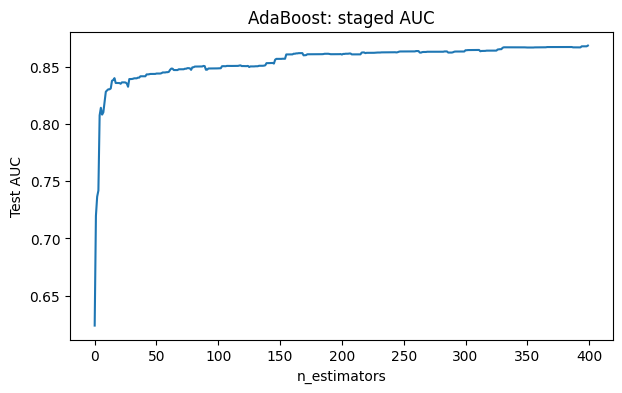

AdaBoost — Final Test AUC= 0.8682719999999999


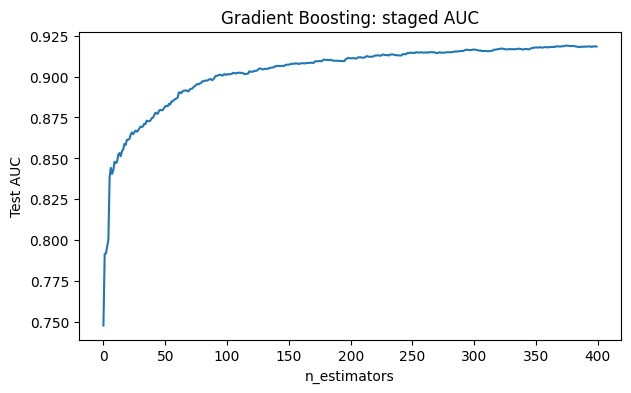

GB — Final Test AUC= 0.9184000000000001


In [7]:
# AdaBoost (stumps)
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
    n_estimators=400, learning_rate=0.1, random_state=42
)
ada.fit(Xtr_syn, ytr_syn)
staged = []
for y_prob in ada.staged_predict_proba(Xte_syn):
    staged.append(roc_auc_score(yte_syn, y_prob[:,1]))
plt.plot(staged); plt.xlabel('n_estimators'); plt.ylabel('Test AUC'); plt.title('AdaBoost: staged AUC'); plt.show()
print('AdaBoost — Final Test AUC=', roc_auc_score(yte_syn, ada.predict_proba(Xte_syn)[:,1]))

# Gradient Boosting (depth=2)
gb = GradientBoostingClassifier(random_state=42, n_estimators=400, learning_rate=0.05, max_depth=2)
gb.fit(Xtr_syn, ytr_syn)
staged_gb = []
for y_prob in gb.staged_predict_proba(Xte_syn):
    staged_gb.append(roc_auc_score(yte_syn, y_prob[:,1]))
plt.plot(staged_gb); plt.xlabel('n_estimators'); plt.ylabel('Test AUC'); plt.title('Gradient Boosting: staged AUC'); plt.show()
print('GB — Final Test AUC=', roc_auc_score(yte_syn, gb.predict_proba(Xte_syn)[:,1]))

**Exercise 3 — Learning rate vs estimators (GB):**
Fix `max_depth=2`. For `learning_rate` in {0.01, 0.05, 0.1} and `n_estimators` in {100, 300, 600}, evaluate test AUC on synthetic data. Plot a small heatmap/table (pandas pivot) and a line plot of AUC vs `n_estimators` for each learning rate.

*Deliverables:* pivot table + plot + 2–3 bullets summarizing bias–variance trade-offs observed.

   learning_rate  n_estimators  test_auc
0           0.01           100  0.868784
1           0.01           300  0.889728
2           0.01           600  0.906016
3           0.05           100  0.901040
4           0.05           300  0.916544
5           0.05           600  0.925968
6           0.10           100  0.909464
7           0.10           300  0.927504
8           0.10           600  0.937104

AUC pivot:
 n_estimators        100       300       600
learning_rate                              
0.01           0.868784  0.889728  0.906016
0.05           0.901040  0.916544  0.925968
0.10           0.909464  0.927504  0.937104


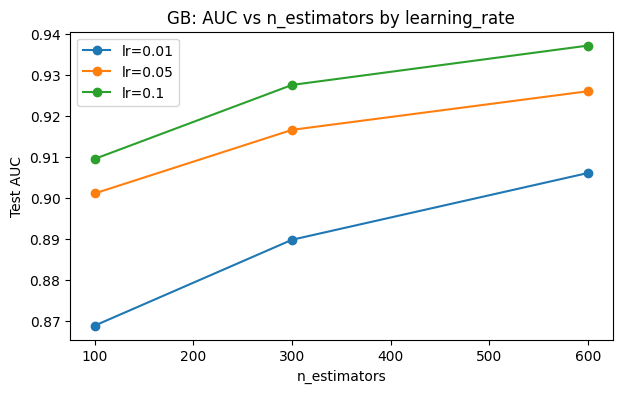

In [8]:
# TODO Exercise 3
rows = []
for lr in [0.01, 0.05, 0.1]:
    for ne in [100, 300, 600]:
        model = GradientBoostingClassifier(random_state=42, max_depth=2, learning_rate=lr, n_estimators=ne)
        model.fit(Xtr_syn, ytr_syn)
        auc = roc_auc_score(yte_syn, model.predict_proba(Xte_syn)[:,1])
        rows.append((lr, ne, auc))
df = pd.DataFrame(rows, columns=['learning_rate','n_estimators','test_auc'])
print(df)
pv = df.pivot(index='learning_rate', columns='n_estimators', values='test_auc')
print('\nAUC pivot:\n', pv)
for lr, sub in df.groupby('learning_rate'):
    sub = sub.sort_values('n_estimators')
    plt.plot(sub['n_estimators'], sub['test_auc'], marker='o', label=f'lr={lr}')
plt.xlabel('n_estimators'); plt.ylabel('Test AUC'); plt.title('GB: AUC vs n_estimators by learning_rate'); plt.legend(); plt.show()
# TODO: Summarize observations in markdown.

---
## 4) Histogram Gradient Boosting (HGB) + Early Stopping

HGB is a faster, regularized gradient boosting (binning continuous features). Support for **early_stopping** can prevent overfitting and save compute.

**Task:** Compare HGB with and without early stopping on synthetic data, report best iteration and test AUC.

In [9]:
# HGB without early stopping
hgb_noes = HistGradientBoostingClassifier(
    learning_rate=0.07, max_depth=None, max_iter=500, random_state=42
).fit(Xtr_syn, ytr_syn)
auc_noes = roc_auc_score(yte_syn, hgb_noes.predict_proba(Xte_syn)[:,1])
print('HGB (no early stopping) — Test AUC=', auc_noes)

# HGB with early stopping
hgb_es = HistGradientBoostingClassifier(
    learning_rate=0.07, max_depth=None, max_iter=2000, early_stopping=True,
    scoring='roc_auc', validation_fraction=0.1, n_iter_no_change=20, random_state=42
).fit(Xtr_syn, ytr_syn)
auc_es = roc_auc_score(yte_syn, hgb_es.predict_proba(Xte_syn)[:,1])
print('HGB (early stopping) — Test AUC=', auc_es)

# Note: sklearn does not expose best_iteration_ for HGBClassifier; we infer via partial dependence / staged preds not available.
# We'll just compare final metrics here.

HGB (no early stopping) — Test AUC= 0.965136
HGB (early stopping) — Test AUC= 0.960816


**Exercise 4 — Partial Dependence (GB/HGB):**
Pick the best performing boosted model (GB or HGB) on the **breast cancer** dataset and plot partial dependence for two informative features (e.g., `mean radius`, `mean texture`).

*Deliverables:* 2 PD plots + 2–3 bullets interpreting the curves.

> Hint: `PartialDependenceDisplay.from_estimator(model, X, features=[i,j])` where `i,j` are column indices.

GB (BC) — Test AUC= 0.9932914046121595


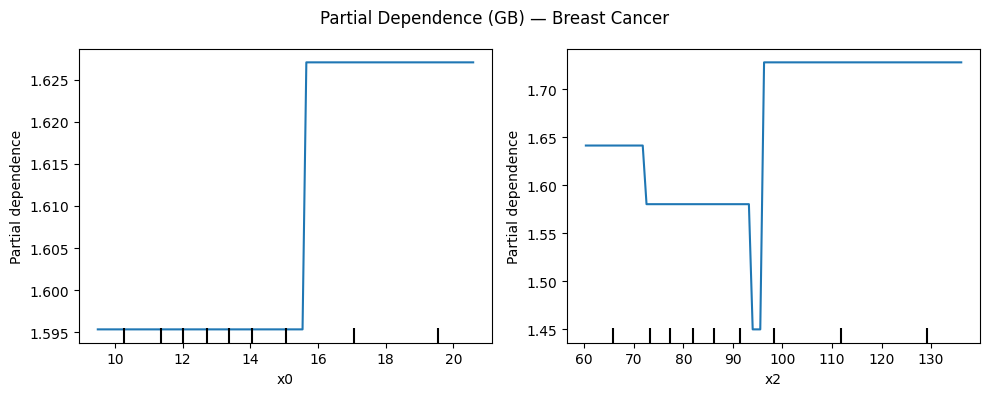

In [10]:
# TODO Exercise 4
# 1) Fit GB or HGB on breast cancer; evaluate AUC
# 2) Choose two strong features (indices) to visualize
gb_bc = GradientBoostingClassifier(random_state=42, n_estimators=400, learning_rate=0.05, max_depth=2)
gb_bc.fit(Xtr_bc, ytr_bc)
print('GB (BC) — Test AUC=', roc_auc_score(yte_bc, gb_bc.predict_proba(Xte_bc)[:,1]))

feat_idx = [0, 2]  # e.g., mean radius, mean perimeter (adjust if desired)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
PartialDependenceDisplay.from_estimator(gb_bc, X_bc, features=[feat_idx[0]], ax=ax[0])
PartialDependenceDisplay.from_estimator(gb_bc, X_bc, features=[feat_idx[1]], ax=ax[1])
fig.suptitle('Partial Dependence (GB) — Breast Cancer'); plt.tight_layout(); plt.show()

# TODO: Write markdown observations below.

---
## 5) Voting & Stacking Ensembles

Blend complementary inductive biases to improve generalization. We'll use **logistic regression**, **k-NN**, and a **random forest** as base models.

**Task:** Build a **hard-voting** and **soft-voting** classifier on the breast cancer dataset; then build a **StackingClassifier** with logistic regression as meta-learner. Compare test AUC/accuracy and confusion matrices.

> Tip: Standardize features for k-NN via a pipeline in the ensemble list.

Voting (hard): acc=0.979, AUC=nan


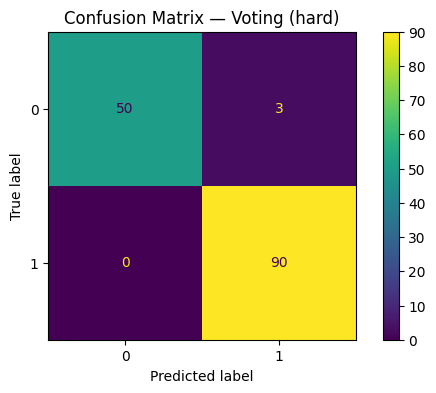

Voting (soft): acc=0.986, AUC=0.998


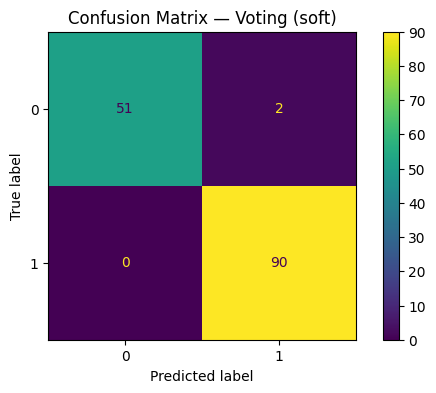

Stacking: acc=0.979, AUC=0.998


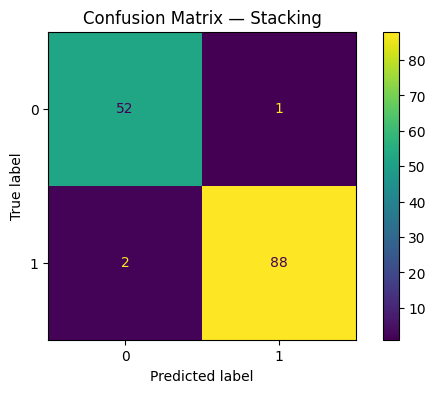

In [11]:
# Base learners
logit = Pipeline([
    ('sc', StandardScaler()),
    ('lr', LogisticRegression(max_iter=2000))
])
knn = Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=15))
])
rf_base = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

# Voting: hard vs soft
v_hard = VotingClassifier(
    estimators=[('logit', logit), ('knn', knn), ('rf', rf_base)],
    voting='hard'
).fit(Xtr_bc, ytr_bc)
v_soft = VotingClassifier(
    estimators=[('logit', logit), ('knn', knn), ('rf', rf_base)],
    voting='soft'
).fit(Xtr_bc, ytr_bc)

def eval_model(name, model, Xte, yte):
    pred = model.predict(Xte)
    if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(Xte)[:,1]
        auc = roc_auc_score(yte, proba)
    else:
        auc = np.nan
    acc = accuracy_score(yte, pred)
    print(f"{name}: acc={acc:.3f}, AUC={auc:.3f}")
    ConfusionMatrixDisplay(confusion_matrix(yte, pred)).plot()
    plt.title(f'Confusion Matrix — {name}')
    plt.show()

eval_model('Voting (hard)', v_hard, Xte_bc, yte_bc)
eval_model('Voting (soft)', v_soft, Xte_bc, yte_bc)

# Stacking with LR meta-learner
stack = StackingClassifier(
    estimators=[('logit', logit), ('knn', knn), ('rf', rf_base)],
    final_estimator=LogisticRegression(max_iter=2000),
    passthrough=False, n_jobs=-1
).fit(Xtr_bc, ytr_bc)
eval_model('Stacking', stack, Xte_bc, yte_bc)

**Exercise 5 — Blend & compare:**
Swap `rf_base` for a tuned `GradientBoostingClassifier` or `HistGradientBoostingClassifier` in the **soft voting** and **stacking** setups. Compare metrics to the original ensembles. Which base set wins, and why?

*Deliverables:* scores table + 2–3 bullet insights about complementarity and calibration.

In [12]:
# TODO Exercise 5
gb_base = GradientBoostingClassifier(random_state=42, n_estimators=300, learning_rate=0.05, max_depth=2)
gb_base.fit(Xtr_bc, ytr_bc)
v_soft_gb = VotingClassifier(
    estimators=[('logit', logit), ('knn', knn), ('gb', gb_base)], voting='soft'
).fit(Xtr_bc, ytr_bc)

stack_gb = StackingClassifier(
    estimators=[('logit', logit), ('knn', knn), ('gb', gb_base)],
    final_estimator=LogisticRegression(max_iter=2000), n_jobs=-1
).fit(Xtr_bc, ytr_bc)

def scores(name, model):
    pred = model.predict(Xte_bc)
    proba = model.predict_proba(Xte_bc)[:,1]
    return [name, accuracy_score(yte_bc, pred), roc_auc_score(yte_bc, proba)]

rows = []
rows.append(scores('SoftVote RF', v_soft))
rows.append(scores('SoftVote GB', v_soft_gb))
rows.append(scores('Stack RF', stack))
rows.append(scores('Stack GB', stack_gb))
df_scores = pd.DataFrame(rows, columns=['model','acc','auc']).sort_values('auc', ascending=False)
print(df_scores)
# TODO: Summarize which ensemble won and hypothesize why.

         model       acc       auc
0  SoftVote RF  0.986014  0.998323
2     Stack RF  0.979021  0.998323
3     Stack GB  0.979021  0.997694
1  SoftVote GB  0.965035  0.997065


---
## Capstone — End-to-End Ensemble Comparison

**Goal:** On the synthetic dataset, compare: 
- Single Tree
- Bagging (tuned)
- RandomForest (tuned)
- GradientBoosting (tuned)
- HistGradientBoosting (tuned)

Use 5-fold CV AUC for model selection, then fit on train and report **test AUC**, **accuracy**, and show **ROC**. Provide a **1–2 paragraph summary** of findings (bias–variance, feature interactions, calibration hints).

CV AUC ranking on training split:
      model    cv_auc
4      HGB  0.960068
2       RF  0.949378
1  Bagging  0.943137
3       GB  0.914105
0     Tree  0.815244
Best model: HGB — Test acc=0.904, AUC=0.965


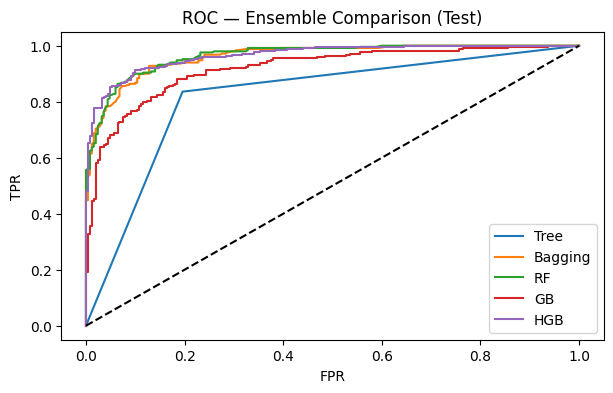

In [13]:
from sklearn.base import clone

cv = KFold(n_splits=5, shuffle=True, random_state=42)

candidates = {
    'Tree': DecisionTreeClassifier(random_state=42),
    'Bagging': BaggingClassifier(estimator=DecisionTreeClassifier(random_state=42), n_estimators=300, n_jobs=-1, random_state=42),
    'RF': RandomForestClassifier(n_estimators=400, max_depth=None, max_features='sqrt', n_jobs=-1, random_state=42),
    'GB': GradientBoostingClassifier(n_estimators=400, learning_rate=0.05, max_depth=2, random_state=42),
    'HGB': HistGradientBoostingClassifier(max_iter=600, learning_rate=0.07, random_state=42)
}

rows = []
for name, model in candidates.items():
    auc_cv = cross_val_score(model, Xtr_syn, ytr_syn, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    rows.append((name, auc_cv))
df_cv = pd.DataFrame(rows, columns=['model','cv_auc']).sort_values('cv_auc', ascending=False)
print('CV AUC ranking on training split:\n', df_cv)

best_name = df_cv.iloc[0]['model']
best_model = clone(candidates[best_name]).fit(Xtr_syn, ytr_syn)
pred = best_model.predict(Xte_syn)
proba = best_model.predict_proba(Xte_syn)[:,1]
acc = accuracy_score(yte_syn, pred)
auc = roc_auc_score(yte_syn, proba)
print(f'Best model: {best_name} — Test acc={acc:.3f}, AUC={auc:.3f}')

for name, model in candidates.items():
    m = clone(model).fit(Xtr_syn, ytr_syn)
    fpr, tpr, _ = roc_curve(yte_syn, m.predict_proba(Xte_syn)[:,1])
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — Ensemble Comparison (Test)'); plt.legend(); plt.show()

# TODO: Add a markdown cell below with your summary/insights.

### What to reflect on
- **Bagging/RF**: variance reduction, robustness to noise, OOB as a free CV.
- **Boosting**: additive modeling captures complex interactions; monitor learning curves to avoid overfit.
- **HGB**: speed & regularization via binning; strong default on tabular data.
- **Ensemble blending**: voting/stacking can combine complementary errors.